
Purpose:
--------
This script applies the Isolation Forest (IF) algorithm to detect anomalies in the TESS light curve
data of star TIC 129646813. The anomalies, interpreted as potential stellar flares, are detected
based on flux deviations.

Workflow:
--------
1. Loading and preprocessing the flux dataset
2. Standardizing flux data
3. Searching for optimal contamination level
4. Applying the Isolation Forest model with specified contamination and random state.
5. Filtering out low-magnitude anomalies using the flux median.
6. Grouping temporally nearby anomalies into flare clusters.
7. Visualizing the detected flares on the light curve.



In [1]:
# Workspace setup
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
# Import data
from google.colab import files
uploaded = files.upload()

Saving 129646813_flux_only.csv to 129646813_flux_only.csv


In [3]:
# Load data and standardize
df = pd.read_csv("129646813_flux_only.csv")
X = df[['pdcsap_flux']].values
X_scaled = StandardScaler().fit_transform(X)  # Standardize for better performance

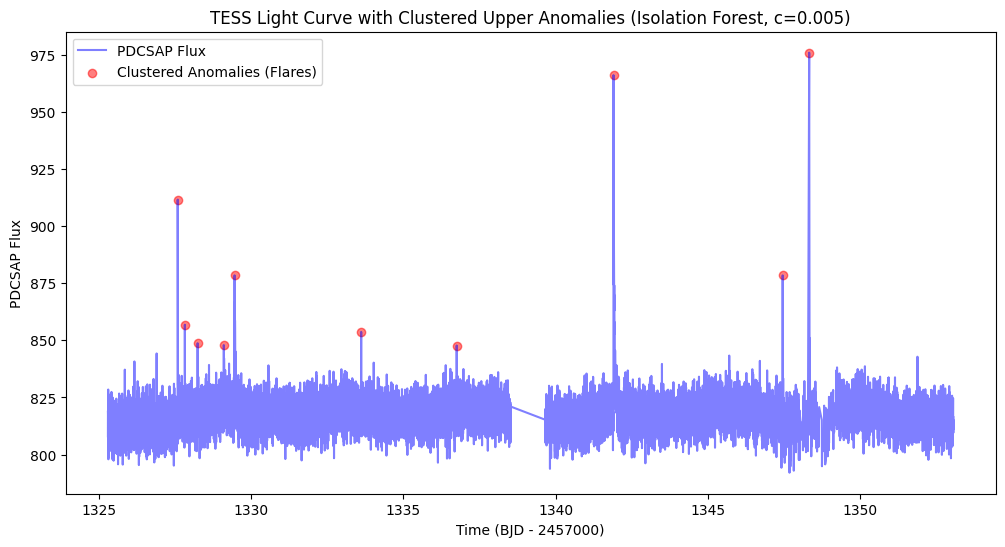

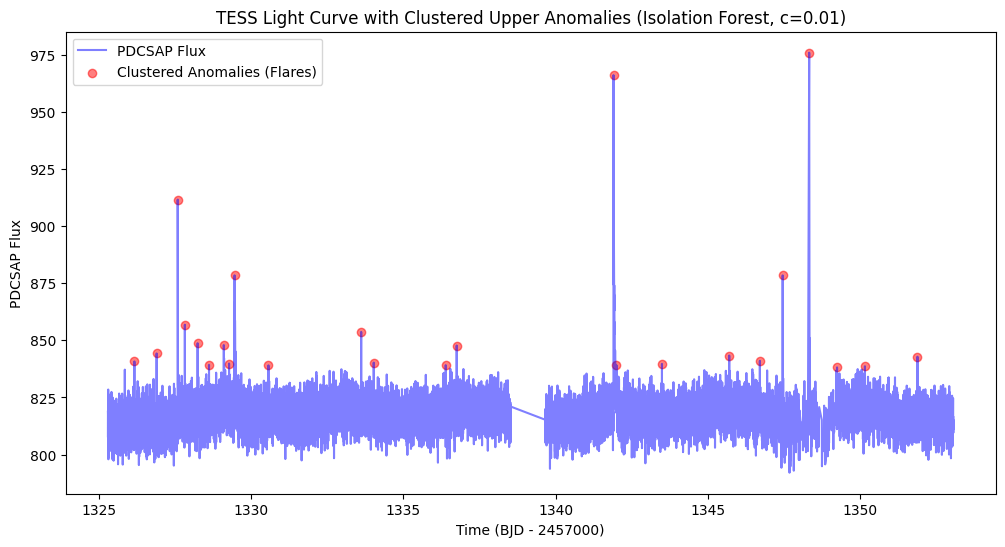

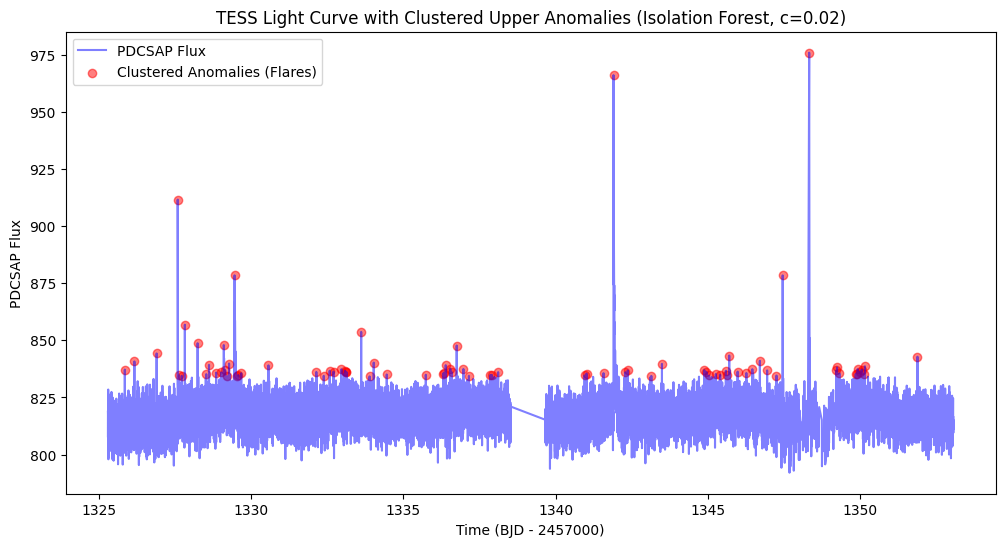

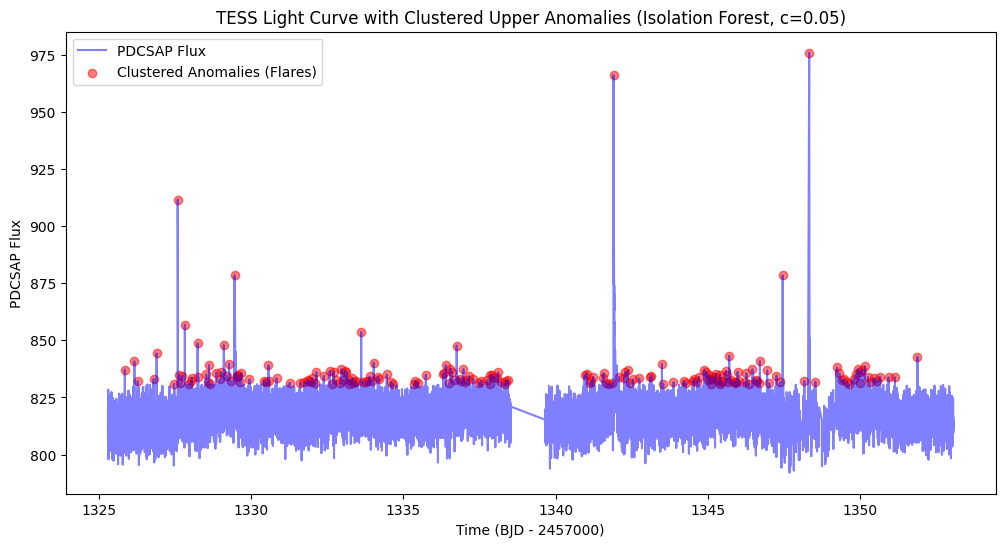

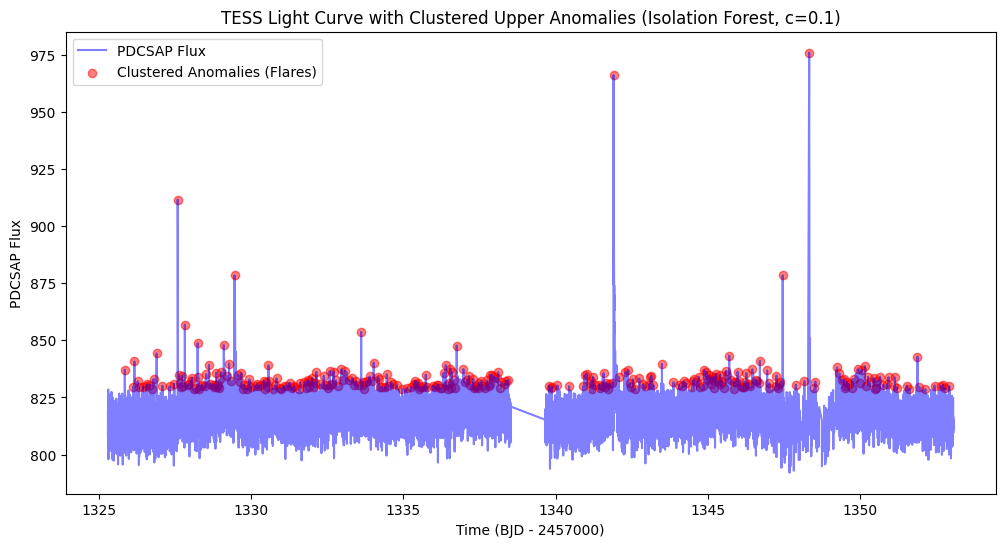

In [ ]:
### Isolation Forest ###
contamination_values = [0.005, 0.01, 0.02, 0.05, 0.1]
for c in contamination_values:
  isoforest = IsolationForest(contamination=c, random_state=42)
  df['anomaly'] = isoforest.fit_predict(X_scaled)  # -1 indicates anomaly
  # Calculate median flux to filter out lower anomalies
  median_flux = df['pdcsap_flux'].median()
  anomalies_above_median = df[(df['anomaly'] == -1) & (df['pdcsap_flux'] > median_flux)]
  # Identify anomaly indices and corresponding times
  anomaly_indices = anomalies_above_median.index
  anomaly_times = df.loc[anomaly_indices, 'time'].values

  # Define a threshold to cluster anomalies within a small time interval (e.g., 0.02 days)
  time_threshold = 0.02
  clustered_anomalies = []
  current_cluster = [anomaly_times[0]]

  # Cluster anomalies based on the time threshold
  for i in range(1, len(anomaly_times)):
      if anomaly_times[i] - anomaly_times[i - 1] <= time_threshold:
          current_cluster.append(anomaly_times[i])
      else:
          # Select the point with maximum flux in the cluster
          cluster_flux = df.loc[df['time'].isin(current_cluster), 'pdcsap_flux']
          max_flux_time = df.loc[cluster_flux.idxmax(), 'time']
          clustered_anomalies.append(max_flux_time)
          current_cluster = [anomaly_times[i]]

  # Add the last cluster if not empty
  if current_cluster:
      cluster_flux = df.loc[df['time'].isin(current_cluster), 'pdcsap_flux']
      max_flux_time = df.loc[cluster_flux.idxmax(), 'time']
      clustered_anomalies.append(max_flux_time)

  # Create a dataframe for clustered anomalies
  clustered_anomalies_df = df[df['time'].isin(clustered_anomalies)]

  # Plot the refined time series with clustered anomalies
  plt.figure(figsize=(12, 6))
  plt.plot(df['time'], df['pdcsap_flux'], label='PDCSAP Flux', color='blue', alpha=0.5)
  plt.scatter(clustered_anomalies_df['time'], clustered_anomalies_df['pdcsap_flux'],
            color='red', label='Clustered Anomalies (Flares)', alpha = 0.5)
  plt.xlabel('Time (BJD - 2457000)')
  plt.ylabel('PDCSAP Flux')
  plt.title(f'TESS Light Curve with Clustered Upper Anomalies (Isolation Forest, c={c})')
  plt.legend()
  plt.show()

In [5]:
### Save models ###
isoforest = IsolationForest(contamination=0.01, random_state=42)
joblib.dump(isoforest, "isolation_forest.pkl")

files.download("isolation_forest.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>